Minimal example that highlights the incompatibility between the ODEs generated by Catalyst and DiffEqGPU:

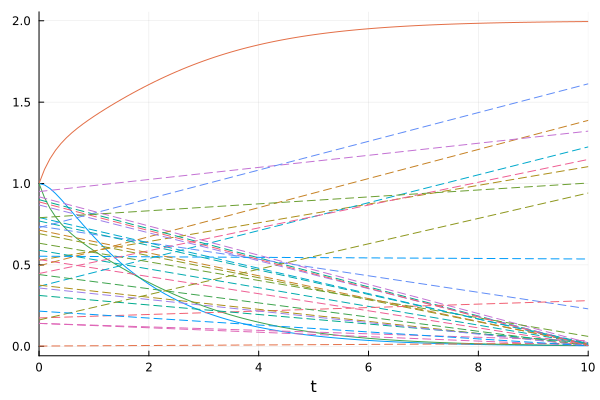

In [14]:
using Catalyst, Plots, DifferentialEquations, CUDA, StaticArrays, DiffEqGPU, StaticArrays

# define a reaction network
rs = @reaction_network begin
  c1, S + E --> SE
  c2, SE --> S + E
  c3, SE --> P + E
end

# setup the ODE problem 
p = @SVector [1.0, 1.0, 1.0]
u0 = @SVector [1.0, 1.0, 1.0, 1.0]
tspan = (0.0, 10.0)
ode = convert(ODESystem, rs)
prob = ODEProblem(ode, u0, tspan, p)

# solve on CPU
sol = solve(prob, Tsit5(), saveat=0.1)
plot(sol, idxs=1:3)

# prepare the problem for the GPU
function change_initial_cond(problem, i, repeat)
  #u0 = @SVector rand(4)
  return remake(problem, u0=rand(4))
end 

multi_problem = EnsembleProblem(prob; prob_func = change_initial_cond, safetycopy=false)

# solve on GPU
function run()
  solutions = solve(multi_problem, GPUTsit5(), EnsembleGPUKernel(CUDA.CUDABackend()), trajectories=10, adaptive = true, reltol=1e-6, abstol=1e-6)
end 

solutions = run()

# plot the results
for s in solutions
    plot!(s, idxs=1:3, linestyle=:dash, legend=false)
end
plot!()

In [15]:
solutions[1]

retcode: Terminated
Interpolation: 1st order linear
t: 1-element view(::Matrix{Float64}, 1:1, 1) with eltype Float64:
 0.1
u: 1-element view(::Matrix{SVector{4, Float64}}, 1:1, 1) with eltype SVector{4, Float64}:
 [0.571185200294971, 0.10696614376593319, 0.3786286457008664, 0.4686458613370261]

In [13]:
using Catalyst, OrdinaryDiffEq, StaticArrays, ModelingToolkit
rn = @reaction_network begin
    kB, S + E --> SE
    kD, SE --> S + E
    kP, SE --> P + E
    d, S --> ∅
end
using OrdinaryDiffEq, Plots
u0 = @SVector [:S => 1.0f0, :E => 1.0f0, :SE => 0.0f0, :P => 0.0f0]
p = @SVector [:kB => 1.0f0, :kD => 0.1f0, :kP => 0.5f0, :d => 0.1f0]
oprob = ODEProblem(rn, u0, (0.0f0, 50.0f0), p)

function prob_func(prob, i, repeat) 
    #prob[:kP] = 0.0001f0*i
    ModelingToolkit.setp(prob, :kP)(prob, 0.0001)
    return prob
end
eprob = EnsembleProblem(oprob; prob_func=prob_func)
nothing

#esol1 = solve(eprob, Tsit5(), EnsembleGPUArray(CUDA.CUDABackend()); trajectories=10000)
esol2 = solve(eprob, GPUTsit5(), EnsembleGPUKernel(CUDA.CUDABackend()); trajectories=10000)
nothing # hide

In [58]:
n_x = 5
txt_crn = "rs = @reaction_network begin" * "\n" * join(["c$(i), X_0 --> X_$(i)" for i in 1:(n_x-1)], "\n") * "\nend"
println(txt_crn)
eval(Meta.parse(txt_crn))
rs

rs = @reaction_network begin
c1, X_0 --> X_1
c2, X_0 --> X_2
c3, X_0 --> X_3
c4, X_0 --> X_4
end


Model ##ReactionSystem#4188
States (5):
  X_0(t)
  X_1(t)
  X_2(t)
  X_3(t)
⋮
Parameters (4):
  c1
  c2
  c3
  c4

In [106]:
using Catalyst, Plots, DifferentialEquations, CUDA, StaticArrays, DiffEqGPU



# define a reaction network
# n_x = 3
# eval(Meta.parse("rs = @reaction_network begin" * "\n" *
#   join(["c$(i), X_0 --> X_$(i)" for i in 1:(n_x-1)], "\n") * "\nend"))


# rs = @reaction_network begin
#   c1, S + E --> SE
#   c2, SE --> S + E
#   c3, SE --> P + E
# end
# n_x = 4

rs = @reaction_network begin
  c1, S + E --> SE
  c2, SE --> S
  c3, SE --> P
end
n_x = 4

# rs = @reaction_network begin
#   c1, X_0 --> X_1
#   c2, X_1 --> X_2
# end
# n_x = 3

# rs = @reaction_network begin
#   c1, S --> SE + S
#   c2, SE --> P
# end
# n_x = 3

# setup the ODE problem 
p = @SVector [1.0 for i in 1:n_x]
u0 = @SVector [1.0 for i in 1:n_x]
tspan = (0.0, 10.0)
ode = convert(ODESystem, rs)
prob = ODEProblem(ode, u0, tspan, p) # the problem must be out-of-place

# solve on CPU
sol = solve(prob, Tsit5(), saveat=0.1)
plot(sol, idxs=1:n_x)

# prepare the problem for the GPU
problem_func = (problem, i, repeat) -> remake(problem, u0=rand(4)) # randomize the initial condition
multi_problem = EnsembleProblem(prob; prob_func = problem_func, safetycopy = false)

# solve on GPU
solutions = solve(multi_problem, GPUTsit5(), EnsembleGPUKernel(CUDA.CUDABackend()), trajectories=10, adaptive = true, reltol=1e-6, abstol=1e-6, saveat=0.1)

# plot the results
for s in solutions
    plot!(s, idxs=1:n_x, linestyle=:dash, legend=false)
end
plot!()

ArgumentError: ArgumentError: Equations (3), states (3), and initial conditions (4) are of different lengths. To allow a different number of equations than states use kwarg check_length=false.

In [125]:
using Catalyst, Plots, DifferentialEquations, CUDA, StaticArrays, DiffEqGPU

# This works fine
# rs = @reaction_network begin
#   c1, S + E --> SE
#   c2, SE --> S + E
#   c3, SE --> P + E
# end
# n_x = 4

# below 32 it works, above it fails
# create n_x-1 reactions of the form X_0 --> X_i
n_x = 33
eval(Meta.parse("rs = @reaction_network begin" * "\n" *
  join(["c$(i), X_0 --> X_$(i)" for i in 1:(n_x-1)], "\n") * "\nend"))

# setup the ODE problem 
p = @SVector [1.0 for i in 1:n_x]
u0 = @SVector [1.0 for i in 1:n_x]
tspan = (0.0, 10.0)
ode = convert(ODESystem, rs)
prob = ODEProblem(ode, u0, tspan, p) # the problem must be out-of-place

# solve on CPU
sol = solve(prob, Tsit5(), saveat=0.1)
plot(sol, idxs=1:n_x)

# prepare the problem for the GPU
problem_func = (problem, i, repeat) -> remake(problem, u0=rand(n_x)) # randomize the initial condition
multi_problem = EnsembleProblem(prob; prob_func = problem_func, safetycopy = false)

# solve on GPU
solutions = solve(multi_problem, GPUTsit5(), EnsembleGPUKernel(CUDA.CUDABackend()), trajectories=10, adaptive = true, reltol=1e-6, abstol=1e-6, saveat=0.1)

# plot the results
for s in solutions
    plot!(s, idxs=1:n_x, linestyle=:dash, legend=false)
end
plot!()

GPUCompiler.InvalidIRError: InvalidIRError: compiling MethodInstance for DiffEqGPU.gpu_ode_asolve_kernel(::KernelAbstractions.CompilerMetadata{KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicCheck, Nothing, CartesianIndices{1, Tuple{Base.OneTo{Int64}}}, KernelAbstractions.NDIteration.NDRange{1, KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicSize, CartesianIndices{1, Tuple{Base.OneTo{Int64}}}, CartesianIndices{1, Tuple{Base.OneTo{Int64}}}}}, ::CuDeviceVector{DiffEqGPU.ImmutableODEProblem{SVector{33, Float64}, Tuple{Float64, Float64}, true, SVector{33, Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, ModelingToolkit.var"#k#503"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xae84faba, 0xca798e0c, 0x0f4ab0aa, 0xacc7e0b8, 0x5dfc199c), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x150edf5a, 0xa4ae4349, 0xa9fcb0e2, 0x7d639c2e, 0x036b7279), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.var"#1269#generated_observed#513"{Bool, ODESystem, Dict{Any, Any}, Vector{SymbolicUtils.BasicSymbolic{Real}}}, Nothing, ODESystem, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, 1}, ::GPUTsit5, ::CuDeviceMatrix{SVector{33, Float64}, 1}, ::CuDeviceMatrix{Float64, 1}, ::Float64, ::CallbackSet{Tuple{}, Tuple{}}, ::Nothing, ::Float64, ::Float64, ::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, ::Val{false}) resulted in invalid LLVM IR
Reason: unsupported call to an unknown function (call to julia.new_gc_frame)
Stacktrace:
 [1] multiple call sites
   @ unknown:0
Reason: unsupported call to an unknown function (call to julia.push_gc_frame)
Stacktrace:
 [1] multiple call sites
   @ unknown:0
Reason: unsupported call to an unknown function (call to julia.get_gc_frame_slot)
Stacktrace:
 [1] multiple call sites
   @ unknown:0
Reason: unsupported call to an unknown function (call to jl_f__apply_iterate)
Stacktrace:
 [1] create_array
   @ ~/.julia/packages/SymbolicUtils/c0xQb/src/code.jl:553
 [2] macro expansion
   @ ~/.julia/packages/SymbolicUtils/c0xQb/src/code.jl:468
 [3] macro expansion
   @ ~/.julia/packages/RuntimeGeneratedFunctions/Yo8zx/src/RuntimeGeneratedFunctions.jl:163
 [4] macro expansion
   @ ./none:0
 [5] generated_callfunc
   @ ./none:0
 [6] RuntimeGeneratedFunction
   @ ~/.julia/packages/RuntimeGeneratedFunctions/Yo8zx/src/RuntimeGeneratedFunctions.jl:150
 [7] multiple call sites
   @ unknown:0
Reason: unsupported call to an unknown function (call to julia.pop_gc_frame)
Stacktrace:
 [1] multiple call sites
   @ unknown:0
Hint: catch this exception as `err` and call `code_typed(err; interactive = true)` to introspect the erronous code with Cthulhu.jl

In [164]:
code = nothing

In [ ]:
using Plots, DifferentialEquations, CUDA, StaticArrays, DiffEqGPU, Symbolics, Catalyst

# works below 33, fails above
n_x = 33
@variables t
D = Differential(t)
@variables X(t)[1:n_x]

eqs = []
for i in 1:n_x
    push!(eqs, D(X[i]) ~ Num(1.0))
end

p = @SVector [1.0 for i in 1:n_x]
u0 = @SVector [1.0 for i in 1:n_x]
tspan = (0.0, 10.0)
sys = @named test = ODESystem(eqs, t)
prob = ODEProblem(sys, u0, tspan, p) # the problem must be out-of-place

# solve on CPU
sol = solve(prob, Tsit5(), saveat=0.1)
plot(sol, idxs=1:n_x)

# prepare the problem for the GPU
problem_func = (problem, i, repeat) -> remake(problem, u0=rand(n_x)) # randomize the initial condition
multi_problem = EnsembleProblem(prob; prob_func = problem_func, safetycopy = false)

# solve on GPU
code = @device_code_typed solve(multi_problem, GPUTsit5(), EnsembleGPUKernel(CUDA.CUDABackend()), trajectories=10, adaptive = true, reltol=1e-6, abstol=1e-6, saveat=0.1)

# # plot the results
# for s in solutions
#     plot!(s, idxs=1:n_x, linestyle=:dash, legend=false)
# end
# plot!()

In [161]:
using Plots, DifferentialEquations, CUDA, StaticArrays, DiffEqGPU, Symbolics, Catalyst

# works below 33, fails above
n_x = 33
@variables t
D = Differential(t)
@variables X(t)[1:n_x]

eqs = []
for i in 1:n_x
    push!(eqs, D(X[i]) ~ Num(1.0))
end

p = @SVector [1.0 for i in 1:n_x]
u0 = @SVector [1.0 for i in 1:n_x]
tspan = (0.0, 10.0)
sys = @named test = ODESystem(eqs, t)
prob = ODEProblem(sys, u0, tspan, p) # the problem must be out-of-place

# solve on CPU
sol = solve(prob, Tsit5(), saveat=0.1)
plot(sol, idxs=1:n_x)

# prepare the problem for the GPU
problem_func = (problem, i, repeat) -> remake(problem, u0=rand(n_x)) # randomize the initial condition
multi_problem = EnsembleProblem(prob; prob_func = problem_func, safetycopy = false)

# solve on GPU
code = @device_code_typed solve(multi_problem, GPUTsit5(), EnsembleGPUKernel(CUDA.CUDABackend()), trajectories=10, adaptive = true, reltol=1e-6, abstol=1e-6, saveat=0.1)

# # plot the results
# for s in solutions
#     plot!(s, idxs=1:n_x, linestyle=:dash, legend=false)
# end
# plot!()

PTX CompilerJob of MethodInstance for DiffEqGPU.gpu_ode_asolve_kernel(::KernelAbstractions.CompilerMetadata{KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicCheck, Nothing, CartesianIndices{1, Tuple{Base.OneTo{Int64}}}, KernelAbstractions.NDIteration.NDRange{1, KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicSize, CartesianIndices{1, Tuple{Base.OneTo{Int64}}}, CartesianIndices{1, Tuple{Base.OneTo{Int64}}}}}, ::CuDeviceVector{DiffEqGPU.ImmutableODEProblem{SVector{32, Float64}, Tuple{Float64, Float64}, true, SVector{32, Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, ModelingToolkit.var"#k#503"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x5e31a10b, 0x2c25ee88, 0x98c5be64, 0x96dff5a3, 0xcda86bfa), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_M

In [ ]:
using Plots, DifferentialEquations, CUDA, StaticArrays, DiffEqGPU, Symbolics, Catalyst

# works below 33, fails above
n_x = 33
@variables t
D = Differential(t)
@variables X(t)[1:n_x]

eqs = []
for i in 1:n_x
    push!(eqs, D(X[i]) ~ Num(1.0))
end

p = @SVector [1.0 for i in 1:n_x]
u0 = @SVector [1.0 for i in 1:n_x]
tspan = (0.0, 10.0)
sys = @named test = ODESystem(eqs, t)
prob = ODEProblem(sys, u0, tspan, p) # the problem must be out-of-place

# solve on CPU
sol = solve(prob, Tsit5(), saveat=0.1)
plot(sol, idxs=1:n_x)

# prepare the problem for the GPU
problem_func = (problem, i, repeat) -> remake(problem, u0=rand(n_x)) # randomize the initial condition
multi_problem = EnsembleProblem(prob; prob_func = problem_func, safetycopy = false)

# solve on GPU
code = @device_code_typed solve(multi_problem, GPUTsit5(), EnsembleGPUKernel(CUDA.CUDABackend()), trajectories=10, adaptive = true, reltol=1e-6, abstol=1e-6, saveat=0.1)

# # plot the results
# for s in solutions
#     plot!(s, idxs=1:n_x, linestyle=:dash, legend=false)
# end
# plot!()

In [172]:
using Cthulhu

UndefVarError: UndefVarError: `active_repl` not defined

In [157]:
for (k,v) in code
    println(k)
    println(v)
end